# Chapter 4: Self-Abnegation in the Sonnets of Clare and Smith

In traditional accounts of Romantic literature, lyric poetry is central and is tightly defined in terms of the 'necessary self'. The Romantic lyric is an 'internalized quest romance' or 'upward spiral', in which the poet describes their experience of nature and moves towards a final recognition of their true identity. While this conception of the Romantic lyric has come under attack in recent years, no alternative understanding of the Romantic lyric has arisen to replace it. This is partly due to proponents of the 'New Lyric Studies', who argue that the only available definition of lyric poetry *is* the definition used in traditional scholarship on Romanticism. The only solution, claim the proponents of the New Lyric Studies, is to set aside the desire to define 'lyric poetry' at all.

In Chapter 4 of *Romanticism and the Contingent Self*, I consider the sonnets of Charlotte Smith and John Clare, two poets whose poems almost never culminate in a recognition of their true identity. Using the example of their sonnets, I try to show how an alternative understanding of the Romantic lyric is possible, one that makes room for a wider variety of poems in our conceptualisation of the 'lyric', while also allowing us to define what the lyric is with tolerable precision.

In this notebook, I generate all the tables and figures for Chapter 4 of the book.

In [1]:
%matplotlib inline

from collections import Counter
from collections.abc import Iterable
from itertools import chain, permutations

from romanticself import SonnetCorpus
from romanticself import import_scheme_map
import pandas as pd
import seaborn as sns
import numpy as np
from nltk import FreqDist

sns.set_theme(style="darkgrid", palette="gray")

In [2]:
sonnets = SonnetCorpus("data/sonnet-corpus/")
rs_map = import_scheme_map("data/sonnet-corpus/schemes.csv")

Extracting Wordsworth's sonnets from wwComplete.xml...
Extracting Smith's sonnets from smithComplete.xml...
Extracting Clare's sonnets from clareComplete.xml...
SonnetCorpus(Wordsworth: 514 [12], Smith: 93 [1], Clare: 638 [53])


In [3]:
def get_author_totals(corpus: SonnetCorpus) -> dict:
    """Get total sonnets per author in convenient format"""
    return Counter([author for author, in sonnets.yield_metadata("author")])

get_author_totals(sonnets)

Counter({'Wordsworth': 514, 'Smith': 93, 'Clare': 638})

## 4.1 Genre: Against Closure

In this section of the Chapter, I consider how Clare, Smith and Wordsworth utilise sonnet conventions. What idea of the sonnet do they present in their sonnets? Each poet uses distinctive patterns of rhyme and metre in their sonnets, displaying different attitudes towards the sonnet tradtion.

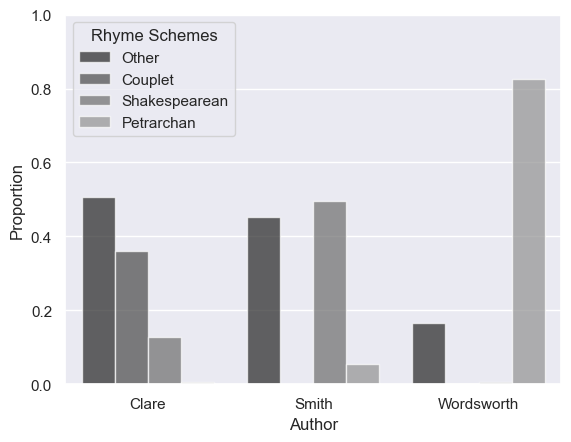

In [4]:
def plot_rhyme_schemes(corpus, normalize=True):
    
    x, hue, y = "Author", "Rhyme Schemes", "Proportion" if normalize else "Count"

    rhyme_schemes = pd.DataFrame([(author, rs_map[rhyme_scheme]) for author,rhyme_scheme in sonnets.yield_metadata("author", "rhyme_scheme")])
    rhyme_schemes.columns = [x, hue]

    rhyme_schemes_data = (rhyme_schemes
                            .groupby("Author")
                            .value_counts(normalize=normalize)
                            .rename(y)
                            .reset_index()
                            )

    plot = sns.barplot(data=rhyme_schemes_data, x=x, y=y, hue=hue, alpha=.7)
    plot.set(ylim=(0,1))

    return plot.get_figure(), rhyme_schemes_data

rhyme_scheme_plot, rhyme_scheme_table = plot_rhyme_schemes(sonnets, True)
rhyme_scheme_plot.savefig("figures/figure_4_1.tiff", dpi=300)
rhyme_scheme_table.to_csv("figures/figure_4_1_data.csv")


In [5]:
def mean_rhyme_sounds_by_poet(corpus):

    def num_sounds(rhyme_scheme):
        # We can use 'max' to get the 'highest' letter in each rhyme-scheme, whose position in the alphabet
        # corresponds to the number of rhyme-sounds in the poem. For instance, if the highest letter is 'e',
        # it means there are 5 unique rhyme sounds
        letter_map = {letter:num+1 for num,letter in enumerate('abcdefghijklmnop')}
        return letter_map[max(rhyme_scheme)]

    rhyme_sounds = corpus.yield_metadata("author", "rhyme_scheme")
    scheme_data = pd.DataFrame([(author, num_sounds(scheme)) for author,scheme in rhyme_sounds])
    scheme_data.columns = ["Author", "Number of Sounds"]
    
    return scheme_data.groupby("Author").mean()

rhyme_sounds_table = mean_rhyme_sounds_by_poet(sonnets)
rhyme_sounds_table.to_excel("figures/table_4_1.xlsx")
rhyme_sounds_table  # type: ignore

,Number of Sounds
Author,
Clare,6.224138
Smith,6.322581
Wordsworth,5.118677


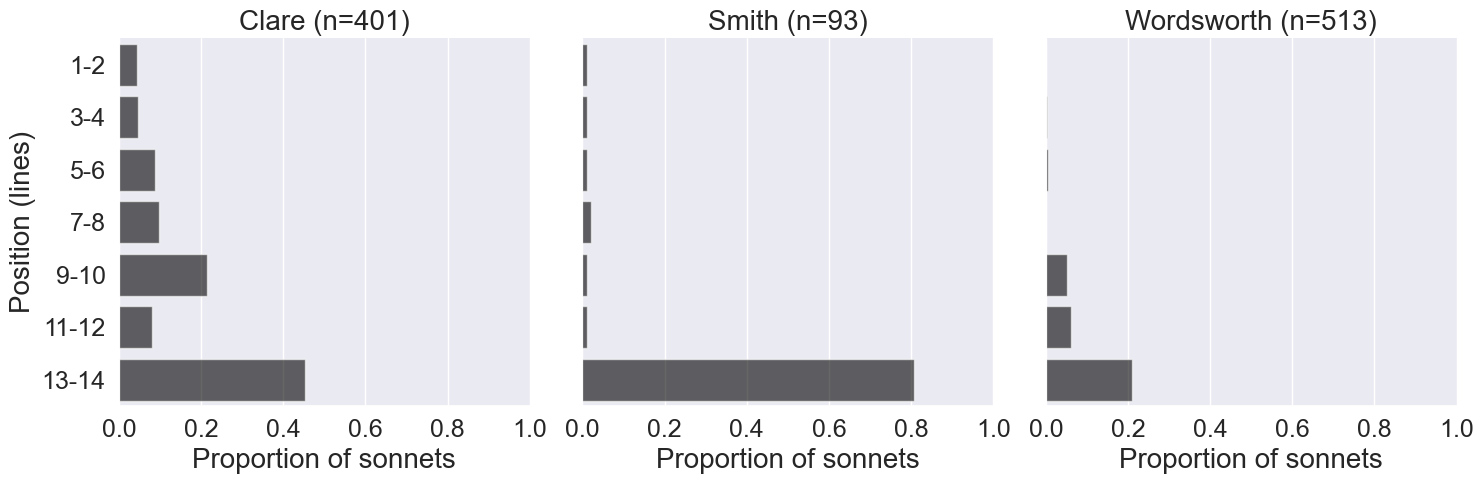

In [22]:
def get_couplet_positions_data(corpus) -> tuple[pd.DataFrame, pd.DataFrame]:

    def is_couplet(rhyme_pair: str) -> bool:
        return rhyme_pair[0] == rhyme_pair[1]

    def compute_positions(rhyme_sounds: str) -> dict:
        positions = {idx:f"{idx+1}-{idx+2}" for idx in range(0, 14, 2)}
        return {position:is_couplet(rhyme_sounds[idx:]) for idx,position in positions.items()}
    
    def _filter(sonnet_list: list[tuple]) -> Iterable:
        """For this specific analysis, sonnets should be exactly 14 lines, and should not have a
        couplet rhyme-scheme"""

        is_not_couplet = lambda x: rs_map[x[1]] != "Couplet"
        is_right_length = lambda x: len(x[1]) == 14

        return filter(lambda x: is_not_couplet(x) and is_right_length(x), sonnet_list)

    rhyme_sounds = corpus.yield_metadata("author", "rhyme_scheme")
    positions_data = pd.DataFrame(
        [{"author":author, **compute_positions(scheme)} for author,scheme in _filter(rhyme_sounds)]
    )
    author_totals = Counter(author for author,_ in _filter(rhyme_sounds))

    positions_summary = (positions_data
            .groupby("author")
            .sum()
            .melt(ignore_index=False, var_name="position", value_name="count")
            .reset_index() # convert 'author' index into column
            .assign(
                total=lambda x: x['author'].map(author_totals),
                prop=lambda x: x['count'] / x['total'],
                author_label=lambda x: x.agg(lambda y: f"{y['author']} (n={y['total']})", axis=1)
            )
            )
    
    return positions_summary, positions_data

def plot_couplet_positions(positions_data: pd.DataFrame):
    facet_plot = sns.catplot(data=positions_data, x="prop", y="position", col="author_label", kind="bar", color="black", alpha=.6)
    return (facet_plot
            .set_titles(col_template="{col_name}", size=20)
            .set(xlim=(0, 1))
            .tick_params("both", labelsize=18)
            .set_axis_labels("Proportion of sonnets", "Position (lines)", fontsize=20)
            .tight_layout())


positions_summary, positions_data = get_couplet_positions_data(sonnets)
positions_summary.to_csv("figures/figure_4_2_data.csv")
positions_plot = plot_couplet_positions(positions_summary)
positions_plot.savefig("figures/figure_4_2.tiff", dpi=300)

In [ ]:
# How often does Clare end a sonnet with a couplet, without having any couplets earlier on in the sonnet?
# False == there is no couplet before the final one
# True == there is a couplet before the final one
(positions_data
    .assign(earlier_couplet=lambda x: x.filter(['1-2','3-4','5-6','7-8','9-10','11-12']).any(axis=1))
    .query('author == "Clare"')
    .query('`13-14`')
    .get('earlier_couplet')
    .value_counts()
)


False    135
True      47
Name: earlier_couplet, dtype: int64

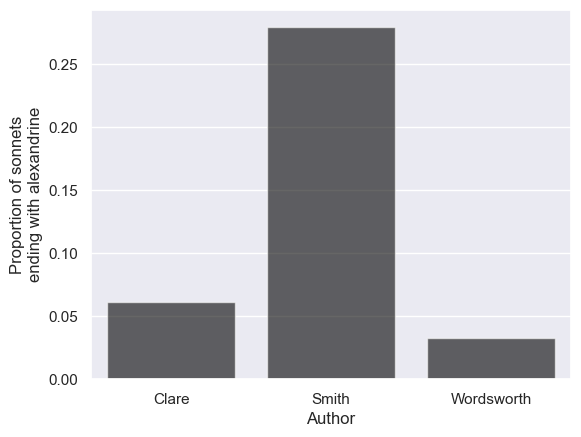

In [ ]:
def get_alexandrine_data(corpus: SonnetCorpus):

    alexandrine = "u-|u-|u-|u-|u-|u-/"

    def ends_with_alx(metre: dict) -> bool:
        # NB: Lines are zero-indexed, as in the couplet-analysis above
        return metre[13] == alexandrine if 13 in metre else False
    
    alexandrine_data = pd.DataFrame(corpus.yield_metadata("author","metre"), columns=["author", "metre"])

    return (alexandrine_data
            .assign(
                ends_with_alx=lambda x: x['metre'].map(ends_with_alx)
                )
            .drop('metre', axis=1)
            .groupby('author')
            .value_counts(normalize=True)
            .rename("prop")
            .reset_index()
            .query('ends_with_alx') # Keep only rows where this is true
            )

def plot_alexandrine_data(alexandrine_data: pd.DataFrame):
    plot = sns.barplot(data=alexandrine_data, x="author", y="prop", color="black", alpha=.6)
    plot.set(xlabel="Author", ylabel="Proportion of sonnets\nending with alexandrine")
    figure = plot.get_figure()
    # Make room for y-axis label, which runs over two lines
    figure.subplots_adjust(left=0.15)
    return figure

alexandrine_data = get_alexandrine_data(sonnets)
alexandrine_plot = plot_alexandrine_data(alexandrine_data)
alexandrine_plot.savefig("figures/figure_4_3.tiff", dpi=300)


## 4.2 Narrative: Sequencing and Paratexts

In this section, I consider how Smith, Clare and Wordsworth narrativise their sonnets. Although sonnets are usually written in a lyrical mode, sonnets frequently contain narrative elements. One way to do this is actually to tell a little story within a sonnet. But poets of the Romantic period generally preferred to narrativise their sonnets in another way: by embedding them in larger narratives. In this section, I consider two techniques that Smith, Clare and Wordsworth use to embed their sonnets in larger narratives: (1) by collecting sonnets into sequences; and (2) by choosing titles for their sonnets which indicate a larger context.

In [ ]:
def get_sequence_table(corpus: SonnetCorpus):
    """Collect summary statistics on how each poet organised their sonnets into sequences."""
    sequence_table = (pd.DataFrame(
        [{"author":author, **values} for (author,_),values in corpus.sequences.items()]
        )
        .drop(['title','sonnets'], axis=1)
        .groupby('author')
        .aggregate(['count','sum','mean']) #type: ignore
        .reset_index()
        .assign(
            total=lambda x: x['author'].map(get_author_totals(corpus)),
            prop=lambda x: x['num_sonnets']['sum'] / x['total']
            )
        ) 

    sequence_table.columns = [
        'Author',
        'Number of sequences',
        'Total sequenced sonnets',
        'Mean sequence length',
        'Total sonnets',
        'Proportion in sequence'
    ]

    return sequence_table   

sequence_table = get_sequence_table(sonnets)
sequence_table.to_excel("figures/table_4_2.xlsx")
sequence_table

,Author,Number of sequences,Total sequenced sonnets,Mean sequence length,Total sonnets,Proportion in sequence
0,Clare,53,134,2.528302,638,0.210031
1,Smith,1,92,92.000000,93,0.989247
2,Wordsworth,12,502,41.833333,514,0.976654


In [ ]:
def longest_sequence_by_author(corpus: SonnetCorpus) -> pd.DataFrame:
    """How long was the longest sequence for each author?"""
    return (pd.DataFrame(
        [{"author":author, **values} for (author,_),values in corpus.sequences.items()]
        )
        .drop(['title','sonnets'], axis=1)
        .groupby('author')
        .aggregate(['max','min']))

longest_sequence_by_author(sonnets)

num_sonnets    
                   max min
author                    
Clare                6   2
Smith               92  92
Wordsworth         132   3

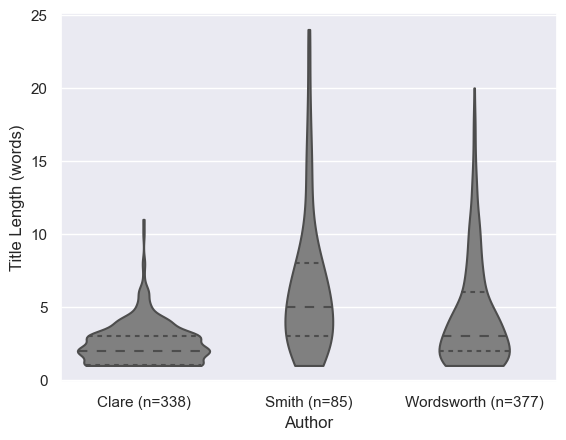

In [ ]:
def get_title_data(corpus: SonnetCorpus) -> pd.DataFrame:
    """Get data frame of title data from corpus"""
    return (pd.DataFrame(
                # Only keep sonnets that have titles
                data=[sonnet for sonnet in corpus.yield_metadata("author", "title") if sonnet[1]],
                columns=["author","title"])
                .assign(title_length=lambda x: x["title"].map(len))
                .drop("title", axis=1))

def plot_title_data(corpus: SonnetCorpus):
    """Plot title lengths as a violin plot"""

    title_data = get_title_data(corpus)
    
    # Add group totals to x axis labels
    author_totals = title_data.groupby("author").count()
    formatted_data = title_data.assign(
                author_total=lambda x: x['author'].map(author_totals['title_length']),
                author_label=lambda x: x.agg(lambda y: f"{y['author']} (n={y['author_total']})", axis=1)
                )
    
    # We want the poets to appear in alphabetical order
    # For some reason seaborn puts WW first on this plot
    my_order = np.sort(formatted_data['author_label'].unique())
    
    plot = sns.violinplot(data=formatted_data, x="author_label", y="title_length",
                            color="grey", inner="quartiles", order=my_order, cut=0)
    plot.set(xlabel="Author", ylabel="Title Length (words)")

    return plot.get_figure()

title_data_plot = plot_title_data(sonnets)
title_data_plot.savefig("figures/figure_4_4.tiff", dpi=300)
    

In [ ]:
def summarise_title_data(corpus: SonnetCorpus):
    """Get summary statistics on sonnet titles"""
    title_data = get_title_data(corpus)

    quartiles = (title_data
                .groupby("author")
                .quantile(q=[0.25, 0.5, 0.75]) #type: ignore
                .reset_index()
                .pivot(index="author", columns="level_1", values="title_length")
                ) 

    quartiles_with_totals = (
        title_data
        .groupby("author")
        .agg("count")
        .reset_index()
        .join(quartiles, on="author")
        )
    
    quartiles_with_totals.columns = [
        "Author",
        "Sonnets with Titles",
        "Title Length Lower Quartile",
        "Title Length Median",
        "Title Length Upper Quartile"
    ]

    return quartiles_with_totals

title_length_summary = summarise_title_data(sonnets)
title_length_summary.to_csv("figures/figure_4_4_data.csv")


In [ ]:
def filter_titles(titles: list[tuple], author: str) -> Iterable:
        return chain.from_iterable([title for auth,title in titles if auth==author])

def get_title_word_frequencies(corpus: SonnetCorpus, n: int|None = None) -> pd.DataFrame:
    """Get the n most frequent words in sonnet tiles by author, in frequency per 1000 words"""

    titles = corpus.yield_metadata("author", "title")

    authors = ["Clare", "Smith", "Wordsworth"]
    frequencies = {author:FreqDist(filter_titles(titles, author)) for author in authors}

    # Get n most common and plot in DataFrame
    if n is not None:
        freq_data = [{"author":auth, "word":wd, "freq":fq/fd.N()*1000} for auth,fd in frequencies.items() for wd,fq in fd.most_common(n)]
    elif n is None:
        freq_data = [{"author":auth, "word":wd, "freq":fq/fd.N()*1000} for auth,fd in frequencies.items() for wd,fq in fd.items()]

    return pd.DataFrame(freq_data)

frequencies = get_title_word_frequencies(sonnets, n=10)
frequencies.to_excel("figures/table_4_3.xlsx")
frequencies


,author,word,freq
0,Clare,the,108.747045
1,Clare,sonnet,48.463357
2,Clare,to,46.099291
3,Clare,a,41.371158
4,Clare,of,34.278960
5,Clare,in,28.368794
6,Clare,spring,16.548463
7,Clare,summer,16.548463
8,Clare,on,13.002364
9,Clare,autumn,13.002364


How many times do these poets use the word 'from' in their titles?

In [ ]:
all_frequencies = get_title_word_frequencies(sonnets)
all_frequencies['rank'] = all_frequencies.groupby(['author'])['freq'].rank(ascending=False)
all_frequencies[all_frequencies['word'] =='from']

,author,word,freq,rank
390,Smith,from,26.515152,8.0
579,Wordsworth,from,6.064281,14.0


## 4.3 Lyric: Person Deixis

In this section of the chapter, I explore self-reference in the sonnets. When Smith, Clare and Wordsworth use words like 'I' and 'my', what are they referring to? This analysis helps to clarify the 'lyrical' aspects of their sonnets.

In [ ]:
first_person = {
    'i':'singular',
    'me':'singular',
    'mine':'singular',
    'my':'singular',
    'myself':'singular',
    'we':'plural',
    'us':'plural',
    'our':'plural',
    'ours':'plural',
    'ourselves':'plural'
}
authors = ['Clare','Smith','Wordsworth']

def get_word_frequency(word: str, sonnets: Iterable[Iterable[str]], per=1000) -> float:
    """Chains together the passed lists of tokens and computes the frequency per the
    desired number of words"""

    freq = 0
    word_count = 0
    
    for token in chain.from_iterable(sonnets):
        word_count += 1
        if token == word:
            freq += 1

    return freq / word_count * per if word_count > 0 else 0

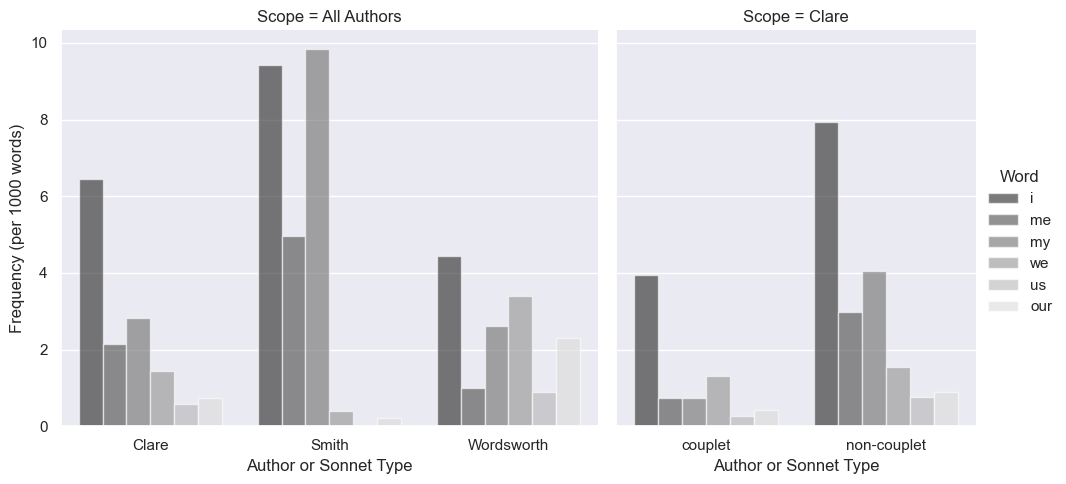

In [ ]:
def plot_word(corpus: SonnetCorpus, authors: Iterable[str], rs_map: dict, words: Iterable[str]):
    """Plot the frequency of a given word across all authors and across Clare's couplet and
    non-couplet sonnets."""

    def _get_all_author_data(corpus: SonnetCorpus, words: Iterable[str], authors: Iterable[str]) -> dict:

        def _get_author_freq(corpus: SonnetCorpus, word: str, author: str) -> float:
            author_corpus = corpus.iter_filter(author=author)
            return get_word_frequency(word, author_corpus)

        return {(author, word): _get_author_freq(corpus, word, author) for author in authors for word in words}

    def _get_clare_data(corpus: SonnetCorpus, words: Iterable[str], rs_map: dict) -> dict:
        """Adds comparison for Clare's couplet and non-couplet sonnets considered
        as seperate corpora."""

        def _is_couplet(sonnet_metadata: tuple[tuple, dict]) -> bool:
            rhyme_scheme = sonnet_metadata[1]['rhyme_scheme']
            return rs_map[rhyme_scheme] == 'Couplet'

        def _is_clare(sonnet_metadata: tuple[tuple, dict]) -> bool:
            return sonnet_metadata[1]['author'] == 'Clare'

        def _get_clare_subsets(corpus: SonnetCorpus) -> dict:
            iterator = corpus.data.items()
            def couplet(x): return _is_couplet(x) and _is_clare(x)
            def non_couplet(x): return not _is_couplet(x) and _is_clare(x)
            return {'couplet': filter(couplet, iterator), 'non-couplet': filter(non_couplet, iterator)}

        def _calculate_subset_freq(word: str, subset: Iterable[tuple]) -> float:
            tokens = chain.from_iterable(
                [data['tokens'] for _, data in subset])
            data = FreqDist(tokens)
            return data[word] / data.N() * 1000

        return {(label, word): _calculate_subset_freq(word, subset) for word in words for label, subset in _get_clare_subsets(corpus).items()}

    data = (pd.DataFrame
            .from_dict({
                'All Authors': _get_all_author_data(corpus, words, authors),
                'Clare': _get_clare_data(corpus, words, rs_map)
            })
            .reset_index()
            .rename({'level_0': 'Author or Sonnet Type', 'level_1': 'Word'}, axis=1)
            .melt(id_vars=["Author or Sonnet Type", "Word"], var_name="Scope", value_name="Frequency (per 1000 words)")
            .dropna()
            )
    
    plot = sns.catplot(data=data, kind="bar", sharex=False, x="Author or Sonnet Type",
                       y="Frequency (per 1000 words)", aspect=1, col="Scope", hue="Word", alpha=0.6,
                       facet_kws={"gridspec_kws": {'width_ratios':[1,0.67]}})

    return plot, data

person_deixis_plot, person_deixis_data = plot_word(sonnets, authors, rs_map, ["i","me","my","we","us","our"])
person_deixis_plot.savefig("figures/figure_4_5.tiff", dpi=300)
person_deixis_data.to_csv("figures/figure_4_5_data.csv")

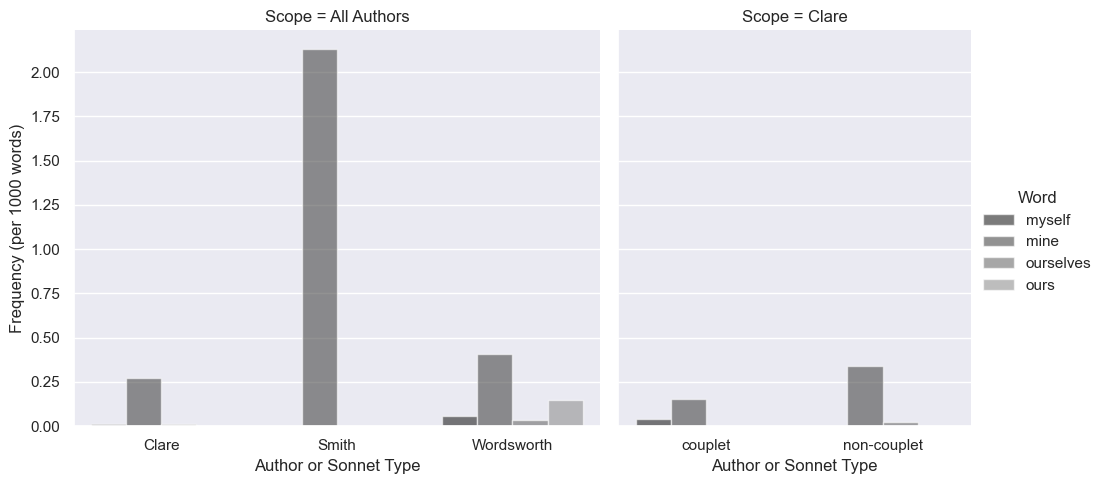

In [ ]:
other_personal_pronouns, other_personal_pronouns_data = plot_word(sonnets, authors, rs_map, ["myself","mine","ourselves","ours"])

In [ ]:
def get_predicate_table(csv_file: str) -> pd.DataFrame:
    """Gets raw predicate data from csv file and transforms into normalised dataframe."""
    raw_data = pd.read_csv(csv_file)
    author_totals = raw_data.groupby(['author','pronoun']).count().rename(columns={"verb":"total"}).reset_index()
    return (raw_data
                .groupby(['author','pronoun','verb'])
                .value_counts()
                .reset_index()
                .rename(columns={0:"count"})              
                .merge(author_totals)
                .assign(
                    frequency=lambda x: x['count']/x['total']*1000,
                    rank=lambda x: x.groupby(['author','pronoun'])['count'].rank(method="first", ascending=False))
                .sort_values(by=['pronoun','author','rank'])
                )

predicate_table = get_predicate_table("data/sonnet_personal_predicates.csv")
predicate_table.to_csv("figures/figure_4_6_data.csv")
predicate_table[predicate_table['frequency'] > 15] # See the top words in a table


,author,pronoun,verb,count,total,frequency,rank
168,Clare,I,love,52,548,94.890511,1.0
66,Clare,I,feel,15,548,27.372263,2.0
1,Clare,I,am,11,548,20.072993,3.0
129,Clare,I,have seen,11,548,20.072993,4.0
246,Clare,I,thought,10,548,18.248175,5.0
479,Smith,I,love,5,121,41.322314,1.0
483,Smith,I,mark,5,121,41.322314,2.0
459,Smith,I,find,4,121,33.057851,3.0
495,Smith,I,see,4,121,33.057851,4.0
521,Smith,I,would,4,121,33.057851,5.0


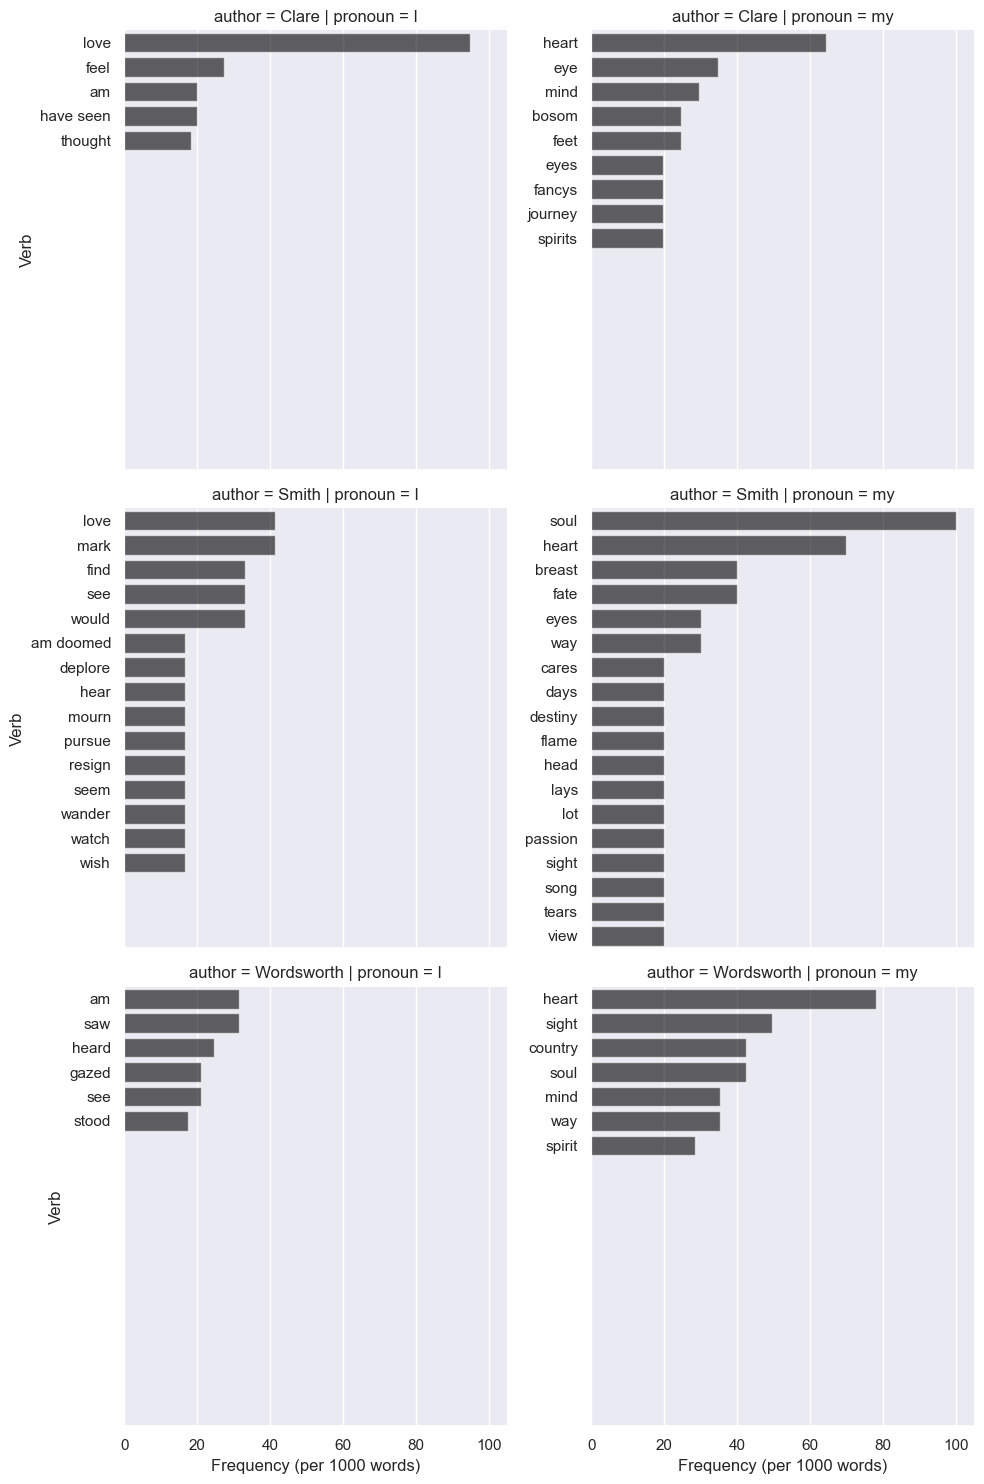

In [ ]:
def plot_predicates(data: pd.DataFrame, min_count: int=1, min_freq: int=15):
    filtered_table = data[(data['frequency'] > min_freq) & (data['count'] > min_count)]
    plot = sns.catplot(data=filtered_table, x="frequency", y="verb", row="author",
                        col="pronoun", kind="bar", sharey=False, color="black", alpha=0.6)

    # Ensure that bars in all suplots are the same width
    max_rank = filtered_table['rank'].max()   
    plot.set(ylim=(max_rank-0.5, -0.5))

    plot.set_axis_labels(x_var="Frequency (per 1000 words)", y_var="Verb")

    return plot

predicates_plot = plot_predicates(predicate_table)
predicates_plot.savefig("figures/figure_4_6.tiff", dpi=300)

In [ ]:
def find_unique_predicates(predicate_table: pd.DataFrame, pairwise: bool=True) -> dict:
    """Finds the unique predicates for each pair of poets in the sample, or for
    each poet compared to all others at once."""

    def _get_author_verbs(data: pd.DataFrame, author: str) -> set:
        """Converts the verb column of the data frame into a set for the
        passed author"""
        return set(data[data['author'] == author]['verb'])
    
    def _compare_author_pair(data: pd.DataFrame, author_pair: tuple[str, str]) -> set:
        """Return a set of predicates used by the source author that are
        not used by the target author."""
        src_set,tar_set = [_get_author_verbs(data, author) for author in author_pair]
        return src_set.difference(tar_set)
    
    def _compare_pairs(data: pd.DataFrame) -> dict:
        """Loop over all possible pairs of authors and find the unique
        predictes for the first author in each case."""
        author_pairs = permutations(data['author'].unique(), r=2)
        return {pair:_compare_author_pair(data, pair) for pair in author_pairs}
    
    def _compare_against_all(data: pd.DataFrame, author: str) -> set:
        src_set = _get_author_verbs(data, author)
        tar_set = set(data[data['author'] != author]['verb'])
        return src_set.difference(tar_set)

    def _compare_authors(data:pd.DataFrame) -> dict:
        authors = data['author'].unique()
        return {author:_compare_against_all(data, author) for author in authors}

    return _compare_pairs(predicate_table) if pairwise else _compare_authors(predicate_table)

def get_unique_predicates_table(data: pd.DataFrame, pronouns: str|Iterable[str] = ("I","my"), freq_threshold: int = 5, pairwise: bool = False) -> pd.DataFrame:

    def _set_to_str(col: pd.Series) -> pd.DataFrame | pd.Series:
        """Takes a set column and converts it into pretty-printed strings"""
        return col.apply(lambda x: ', '.join(sorted(x)))
    
    def _fil_by_pn(data: pd.DataFrame, pronoun: str) -> pd.DataFrame:
        return data[data['pronoun'] == pronoun]
    
    def _get_pn_data(data: pd.DataFrame, pronoun: str, pairwise: bool = False) -> dict:
        return find_unique_predicates(_fil_by_pn(data, pronoun), pairwise)

    _data = data[data['frequency'] > freq_threshold]

    match pronouns:
        case str() as pronouns:
            _pronouns = [pronouns]
        case Iterable() as pronouns:
            _pronouns = pronouns
    
    records = {pronoun:_get_pn_data(_data, pronoun, pairwise) for pronoun in _pronouns}

    return pd.DataFrame(records).apply(_set_to_str, axis=1)
            
unique_predicates = get_unique_predicates_table(predicate_table, pairwise=False, freq_threshold=5)
unique_predicates.to_excel("figures/table_4_4.xlsx")
unique_predicates



,I,my
Clare,"address, bend, felt, had known, have been, hav...","ashes, breath, end, eye, face, fancys, foot, h..."
Smith,"admire, am doomed, aspire, bade, bear, bless, ...","and, angel, anna, anna's, blood, brain, care, ..."
Wordsworth,"applaud, beheld, behold, call, caught, compare...","affection, bands, beloved, blessing, boat, bro..."


## 4.4 Lyric: Place Deixis

Another crucial lyrical aspect of these sonnets is their use of place deixis: how to Clare, Smith and Wordsworth situate themselves in space in their sonnets? Do they describe a specific, concrete environment at a specific time? Do they describe places they visit repeatedly? Do they focus on what is close and clear or on what is far and fuzzy?

These are huge questions. To get a flavour of these poets' place deixis, I focus just on demonstrative pronouns.

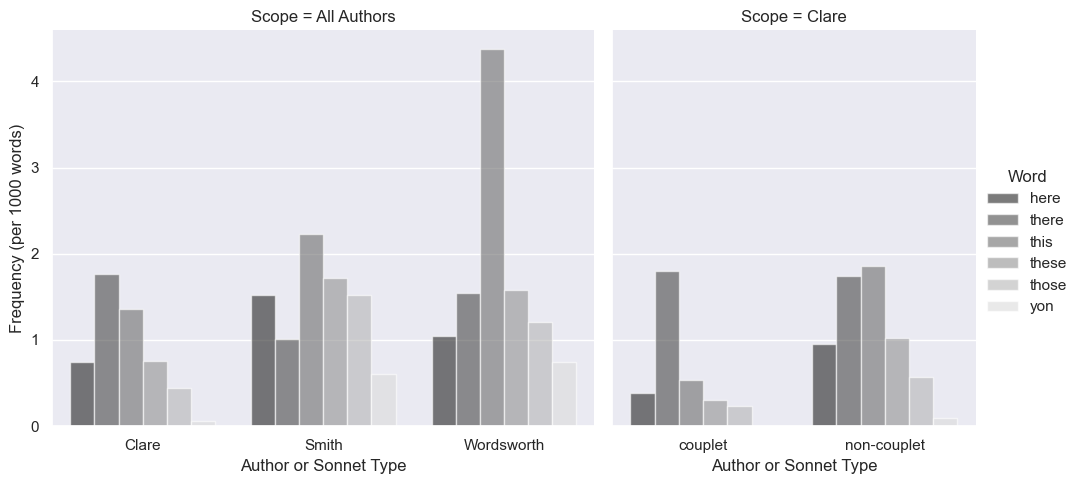

In [ ]:
place_deixis_plot, place_deixis_data = plot_word(sonnets, authors, rs_map, ["here","there","this","these","those","yon"])
place_deixis_plot.savefig("figures/figure_4_7.tiff", dpi=300)
place_deixis_data.to_csv("figures/figure_4_7_data.csv")

Are the words *this* and *here* correlated in these sonnets? Is a sonnet more likely to contain the other word if it contains one of them?

In [ ]:
from scipy.stats.contingency import crosstab
from scipy.stats import fisher_exact

def get_biword_contingency(corpus: SonnetCorpus, authors: Iterable[str], words:tuple[str, str]) -> dict:
    contingency_tables = {}

    def _detect_word(word: str, sonnet: Iterable[str]) -> str:
        return f"+{word}" if word in sonnet else f"-{word}"

    for author in authors:
        word_0 = [_detect_word(words[0], sonnet) for sonnet in sonnets.iter_filter(author=author)]
        word_1 = [_detect_word(words[1], sonnet) for sonnet in sonnets.iter_filter(author=author)]
        contingency_tables[author] = crosstab(word_0, word_1)
    return contingency_tables

def print_contingency_tables(corpus: SonnetCorpus, authors: Iterable[str], words:tuple[str, str]) -> dict:
    contingency_tables = get_biword_contingency(corpus, authors, words)
    for author,contingency in contingency_tables.items():
        (aval, xval), table = contingency
        print(f"Author: {author}")
        print(f"{aval[0]:>12}{aval[1]:>6}")
        print(f"{xval[0]:>6}{table[0][0]:>6}{table[0][1]:>6}")
        print(f"{xval[1]:>6}{table[1][0]:>6}{table[1][1]:>6}")
        print(fisher_exact(table, alternative="greater"), "\n")
    return contingency_tables

this_and_here_contingencies = print_contingency_tables(sonnets, authors, ("this", "here"))

Author: Clare
       +this -this
 +here    17    63
 -here    26   532
SignificanceResult(statistic=5.521367521367521, pvalue=2.7451118893317544e-06) 

Author: Smith
       +this -this
 +here     3    15
 -here    10    65
SignificanceResult(statistic=1.3, pvalue=0.48133271789837806) 

Author: Wordsworth
       +this -this
 +here    25   165
 -here    28   296
SignificanceResult(statistic=1.6017316017316017, pvalue=0.07140298863879868) 

